# An introduction to Jiminy


Jiminy is a simulation framework built around the `pinocchio` rigidbody dynamics library, targeting the simulation of robotic systems. This document covers the use of jiminy in python for individual robotic simulation: usage in C++ is similar, see C++ API documentation and examples. For information about using jiminy in a learning context with Gym OpenAI, see examples in gym_jiminy. 

Jiminy supports the following features:

 - Simulating a single robot, represented by a URDF file, with possible ground interaction (modeled as a spring-damper mechanism). Note that interaction forces are only applied at user-specified frames, there is no mesh collision handling in jiminy for now.
 - Adding joint flexibility, modeled as a Serie-Elastic actuator.
 - Applying external forces on the system.
 - Applying kinematic constraints, such as fixed-body constraints.
 - Simulating multiple robots interacting, including closed kinematic trees.
 - Adding basic sensors on the system

## Basic example

To illustrate the first part of this tutorial, we will use as example the stabilization of a simple inverted pendulum.

Jiminy simulation rely on interfacing three fundamental objects : a Robot, a Controller, defining input for this robot, and an Engine, performing the integration. For convenience, connection between these objects is handled in python by the BasicSimulator class (this class does not exist in C++). Of course, it is always possible to instanciate these objects manually for more specific usage - see the unit tests for examples.

The robot is constructed from a URDF - this builds a jiminy.Model object - but extra information needs to be provided as well for a simulation: which sensors to use and what are their caracteristic ? Which joints have a motor attached and what are its properties ? What are the contact points with the ground (if any) ? All this are informations gathered to build a full robot.

So let's get our first example running: we set the inverted pendulum away from its upward position and watch it fall.

In [1]:
%matplotlib notebook

In [2]:
import os
from pkg_resources import resource_filename

import numpy as np

import jiminy_py.core as jiminy  # The main module of jiminy - this is what gives access to the Robot
from jiminy_py.simulator import Simulator


data_root_path = resource_filename(
    "gym_jiminy.envs", "data/toys_models/simple_pendulum")
urdf_path = os.path.join(data_root_path, "simple_pendulum.urdf")

# Instantiate and initialize the robot
robot = jiminy.Robot()
robot.initialize(urdf_path, mesh_package_dirs=[data_root_path])

# Add a single motor
motor = jiminy.SimpleMotor("PendulumJoint")
robot.attach_motor(motor)
motor.initialize("PendulumJoint")

# Define the command: for now, the motor is off and doesn't modify the output torque.
def compute_command(t, q, v, sensors_data, command):
    command[:] = 0.0

# Instantiate and initialize the controller
controller = jiminy.ControllerFunctor()
controller.initialize(robot)

# Create a simulator using this robot and controller
simulator = Simulator(robot, controller)

# Set initial condition and simulation length
q0, v0 = np.array([0.1]), np.array([0.0])
simulation_duration = 10.0

# Launch the simulation
simulator.simulate(simulation_duration, q0, v0)

  0%|          | 0.00/10.0 [00:00<?]

The simulation generates a log of its computation: this log can be retrieved by using ```simulator.log_data``` - and written to a file for latter processing by the engine with ```simulator.engine.write_log```.

<IPython.core.display.Javascript object>


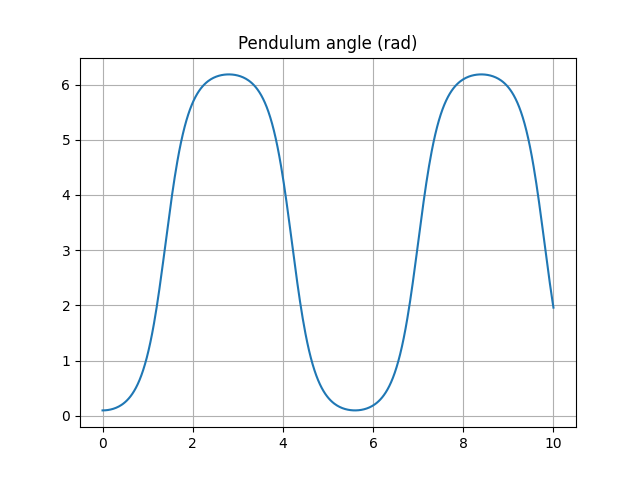

In [3]:
# Get dictionary of logged scalar variables
log_vars = simulator.log_data['variables']

# Let's plot the joint position to see the pendulum fall.
import matplotlib.pyplot as plt

plt.plot(log_vars['Global.Time'], log_vars['HighLevelController.currentPositionPendulum'])
plt.title('Pendulum angle (rad)')
plt.grid()
plt.show()

The results of a simulation can also be visualized in a 3D viewer: either `panda3d` or `meshcat`. We use the latter here as it can be integrated in jupyter.

In [4]:
camera_xyzrpy = ([5.0, 0.0, 2.0e-5], [np.pi/2, 0.0, np.pi/2])
simulator.replay(camera_xyzrpy=camera_xyzrpy)

Let's now add a controller: a simple PD to hold the pendulum straight.

In [5]:
Kp = 5000
Kd = 0.05

# Create a new controller with Proportional-Derivative command
def compute_command(t, q, v, sensors_data, command):
    command[:] = - Kp * (q + Kd * v)

controller = jiminy.ControllerFunctor(compute_command)
controller.initialize(robot)

# Update the simulator to use the new controller
simulator.set_controller(controller)

jiminy_py.core.hresult_t.SUCCESS

## Adding external forces.

External forces can be applied to the system through a force profile : a function outputing a force on
a specific body as as a function of time dans state.

In [6]:
# Apply a force of 500N in the Y direction between t = 2.5 and t = 3s
def force_profile(t, q, v, f):
    if t > 2.5 and t < 3:
        f[1] = 200.0
    else:
        f[1] = 0.0

# Apply this force profile to a given frame.
simulator.engine.register_force_profile("PendulumMass", force_profile)
simulator.simulate(simulation_duration, q0, v0)

# Replay the simulation with new controller and external forces
simulator.replay(camera_xyzrpy=camera_xyzrpy)

  0%|          | 0.00/10.0 [00:00<?]

<IPython.core.display.Javascript object>


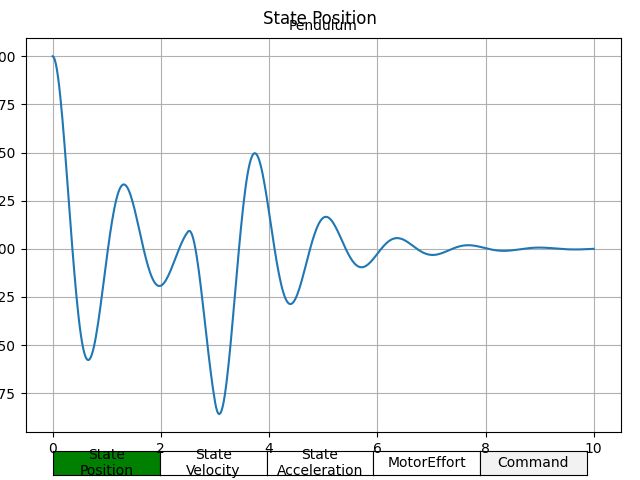

In [7]:
simulator.plot()